# RL homework 1
**Due date: Monday 4 February 2019, 9am**

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

Name: Jeremy Dang

Student number: 17097407

**How to submit**

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`studentnumber_RL_hw1.ipynb`** before the deadline above.

We will process the notebook with a tool similar to Jupyter nbconvert, to turn it into a PDF, while excluding the cells with code (many of which are boilerplate).  If you carefully follow the instructions, the coding you have to do will be printed to output as well, and therefore will show up in the PDF.  Feel free to create a PDF with nbconvert as well, if you want to check whether everything looks okay.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 and 2

**Overview of this assignment**

You will use Python to implement several bandit algorithms.

You will then run these algorithms on a multi-armed Bernoulli bandit problem, to understand the issue of balancing exploration and exploitation.

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section with the little triangle on the left of the word **Setup** above.

In [0]:
# Import Useful Libraries

import collections
from functools import partial
import importlib
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [0]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [0]:
class RovingBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=500,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [0]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def one_hot(array, depth):
  """Multi-dimensional one-hot."""
  a = np.array(array)
  x = a.flatten()
  b = np.eye(depth)[x, :depth]
  return b.reshape(a.shape + (depth,))

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 3
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(8, 3*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)

  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg in current_algs:
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.6, label=alg.name)[0]
        else:
          line = plt.plot(m, alpha=0.6, label=alg.name)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], '--k', label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    action_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        action_dict[alg.name][_rep, _step] = action
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, action_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=30,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.25, 0.75 + 1e-6, 0.5/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, actions, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

## Basic Agents

This section contains a few agents we implemented for you.  Please read the code and make sure you understand the interface of the agents.

In [0]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = 'random'

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass

In [0]:
class Greedy(object):
  """A greedy agent.

  This agent returns an action between 0 and 'number_of_arms', by always
  selecting the action with the highest estimated value.
  """

  def __init__(self, number_of_arms):
    """Initialise the agent."""
    self._number_of_arms = number_of_arms
    self.name = 'greedy'
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input).  Then, the greedy action
    is returned according to the current (updated) statistics.
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      self._estimates[previous_action] += (r - q_a)/n_a
    action = argmax(self._estimates)
    
    return action

  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    
    This is also used to initialise these statistics on initialisation.
    """
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

In [0]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, number_of_arms, epsilon=0.1):
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon
    self.name = '$\epsilon$-greedy with $\epsilon$ = {}'.format(epsilon)
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.
    
    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).
    
    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    if previous_action is not None:
      self._counts[previous_action] += 1.
      r = reward
      q_a = self._estimates[previous_action]
      n_a = self._counts[previous_action]
      self._estimates[previous_action] += (r - q_a)/n_a
    if np.random.random() < self._epsilon:
      action = np.random.randint(self._number_of_arms)
    else:
      action = argmax(self._estimates)
    return action

  def reset(self):
    """Resets all the statistics (estimated rewards and counts) to zero.
    
    This is also used to initialise these statistics on initialisation.
    """
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

# REINFORCE: softmax policies

Derive a REINFORCE policy-gradient method for a multi-armed bandit problem.

The policy is a softmax on action preferences, with temperature T:
$$\pi(a) = \frac{\exp(p(a)/T)}{\sum_b \exp(p(b)/T)}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

In the next text field (under **Q1**), write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$, given the preferences $p_t(\cdot)$, and assuming you selected a specific action $A_t \in \{a_1, \ldots, a_n\}$ and received a reward of $R_t$.

## Q1
**[5 pts]** **Instructions**: please provide answer **in this text cell*:

*Answer here*
\begin{align*}
p_{t+1}(a)
& = p_t(a) + \frac{{\alpha}}{T}{R_t}{(1-{\pi_t{(a)}})}
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = p_t(b) - \frac{{\alpha}}{T}{R_t}{{\pi_t{(b)}}}
&& \text{for all $b \ne A_t$}
\end{align*}

# REINFORCE: different parametrization

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice.

Consider for instance the `square-max` policy parameterization, on action preferences $p(\cdot)$:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Derive a REINFORCE policy-gradient method for updating the preferences under this policy distribution.

As before, the action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

In the next text field (under **Q2**), write down the update function to the preferences for all actions $\{a_1, \ldots, a_n\}$,
given the preferences $p_t(\cdot)$, and assuming you selected a specific action $A_t \in \{a_1, \ldots, a_n\}$ and received a reward of $R_t$.

## Q2
**[5 pts]** **Instructions**: please provide answer in markdown below **within this text cell**.

*Answer here*

\begin{align*}
p_{t+1}(a)
& = p_t(a) + \frac{2{\alpha}{R_t}}{p_t(a)}{(1-{\pi_t{(a)}})}
&& \text{for $a = A_t$} \\
p_{t+1}(b)
& = p_t(b) - \frac{2{\alpha}{R_t}}{p_t(b)}{{\pi_t{(b)}}}
&& \text{for all $b \ne A_t$}
\end{align*}

# Agent implementations


All agents should be in pure Python.

You cannot use TensorFlow or other AutoDiff packages to compute gradients.

It is fine to use TF-Eager or Numpy for other calculations.

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

The `name` attribute set by the agent's constructor should be unique (e.g., 'greedy', 'ucb', etc.)



## Q3
**[10 pts]** You should **implement** an agent that **explores with UCB**. 

The **whole agent** needs to be contained in the code cell below.  Do **not** use multiple cells.

In [0]:
%%writefile rl1_3.py 

class UCB(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.reset()

  def step(self, previous_action, reward):
    # Ensure that agent can handle case is not None
    
    # Using similar notation to say Greedy() and EpsilonGreedy() 
    if previous_action is not None:
      self._counts[previous_action] += 1 # the time steps
      
      r = reward # the R_t's in lecture notes
      
      q_a = self._estimates[previous_action] # the action values q(a) in lecture notes
      
      n_a = self._counts[previous_action] # the N_t's in lecture notes - # of times action occured
      
      self._estimates[previous_action] += (r - q_a) / n_a # total regret, n_a = 1/alpha
      
      # Apply UCB algorithm by following formula in notes in week 2
    t = np.sum(self._counts) # summing our self ._counts gives us total time steps
    
    ucb_action = np.sqrt(np.log(t) / (2*(self._counts)))
    ucb_action[np.isnan(ucb_action)] = 0 # when n_a is 0 choose maximising action
    
      
    actions = self._estimates + ucb_action # this is Q_t(a) + the sqrt part
    
      
      # Need the argmax over ucb_action as stated in lecture notes

      
    return argmax(actions)

  def reset(self):
    self._estimates = np.zeros((self._number_of_arms,))
    self._counts = np.zeros((self._number_of_arms,))

Overwriting rl1_3.py


In [0]:
# Don't modify this cell
print('** Answer 3')
print('[10 pts]')
f = open('rl1_3.py')
ucb_string = ''.join(f.readlines())
exec(compile(ucb_string, 'ucb', 'exec'))
print(ucb_string)
f.close()

** Answer 3
[10 pts]

class UCB(object):

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'ucb'
    self.reset()

  def step(self, previous_action, reward):
    # Ensure that agent can handle case is not None
    
    # Using similar notation to say Greedy() and EpsilonGreedy() 
    if previous_action is not None:
      self._counts[previous_action] += 1 # the time steps
      
      r = reward # the R_t's in lecture notes
      
      q_a = self._estimates[previous_action] # the action values q(a) in lecture notes
      
      n_a = self._counts[previous_action] # the N_t's in lecture notes - # of times action occured
      
      self._estimates[previous_action] += (r - q_a) / n_a # total regret, n_a = 1/alpha
      
      # Apply UCB algorithm by following formula in notes in week 2
    t = np.sum(self._counts) # summing our self ._counts gives us total time steps
    
    ucb_action = np.sqrt(np.log(t) / (2*(self._counts)))
    ucb_ac

## Q4

**[10 pts]** You should **implement a softmax REINFORCE agent with** and **without a baseline**.

The **whole agent** needs to be contained in the code cell below.  Do **not** use multiple cells.

The constructor should take as arguments:
*  `number_of_arms`, (int), number of discrete actions,
*  `baseline`: (boolean, default False), whether or not to use an average-reward baseline,
*  `step_size`: (float, default 0.1), the step-size for the updates,
*  `temperature`: (float, default 1.0), the temperature of the softmax policy, .


In [0]:
%%writefile rl1_4.py
class REINFORCE(object):

  def __init__(
      self, number_of_arms, step_size=0.1, baseline=False, temperature=1.0):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self._baseline = baseline
    self._temperature = temperature
    self.name = 'reinforce, baseline: {}, temperature: {}'.format(
        baseline, temperature)
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
      self._counts += 1
      # set up the average reward aka natural baseline
      self._naturalbaseline = self._naturalbaseline * (reward - self._naturalbaseline) / self._counts
      
      # case if we have a baseline
      if self._baseline == True:
        # reward will be just the baseline
        reward += self._naturalbaseline
      
      
      # set up preferences using lecture notes
      # for case p_t(b) 
      self._preference = self._preference - self._lr*(reward)*(self._policy)
      
      # for case p_t(a) 
      self._preference[previous_action] += self._lr*reward
      
      # policy is softmax with temperature
      self._policy = np.exp(self._preference /self._temperature) / np.sum(np.exp(self._preference/self._temperature))
      
        
    return np.random.choice([i for i in range(self._number_of_arms)] , p = self._policy)   
      
  def reset(self):
    # reset all parameters to 0 
    
    self._preference = [0 for i in range(self._number_of_arms)]
    self._policy = np.exp(self._preference) / np.sum(np.exp(self._preference))
    self._counts = 0
    self._naturalbaseline = 0

Overwriting rl1_4.py


In [0]:
# Don't modify this cell
print('** Answer 4')
print('[10 pts]')
f = open('rl1_4.py')
reinforce_string = ''.join(f.readlines())
exec(compile(reinforce_string, 'reinforce', 'exec'))
print(reinforce_string)
f.close()

** Answer 4
[10 pts]
class REINFORCE(object):

  def __init__(
      self, number_of_arms, step_size=0.1, baseline=False, temperature=1.0):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self._baseline = baseline
    self._temperature = temperature
    self.name = 'reinforce, baseline: {}, temperature: {}'.format(
        baseline, temperature)
    self.reset()

  def step(self, previous_action, reward):
    if previous_action is not None:
      self._counts += 1
      # set up the average reward aka natural baseline
      self._naturalbaseline = self._naturalbaseline * (reward - self._naturalbaseline) / self._counts
      
      # case if we have a baseline
      if self._baseline == True:
        # reward will be just the baseline
        reward += self._naturalbaseline
      
      
      # set up preferences using lecture notes
      # for case p_t(b) 
      self._preference = self._preference - self._lr*(reward)*(self._policy)
      
      # for case p_t(a)

# Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [0]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(number_of_arms),
    Greedy(number_of_arms),
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide
/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


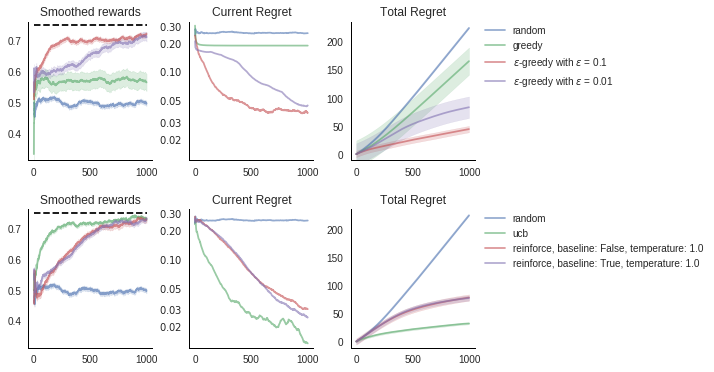

In [0]:
experiment1.show()

## Q5
(Answer inline in the markdown below each question, **within this text cell**.)

**[5pts]** Name the best and worst algorithms, and explain (with one or two sentences each) why these are best and worst.

Assuming that we look at the results from Experiment 1, the best algorithm would be UCB as the total regret is the lowest among the algorithms - i.e UCB is achieving one of the goals in RL to minimise the total regret when trading off exploration vs exploitation.

The worst algorithm would be epsilon greedy with epsilon = 0.1. due to having the lowest total regret and we know that epsilon greedy will select all suboptimal actions with some known probability.

**[5pts]** Which algorithms are guaranteed to have linear total regret?

Random, Greedy and Epsilon-greedy algorithms have linear total regret.

**[5pts]** Which algorithms are guaranteed to have logarithmic total regret?

UCB and REINFORCE algorithms

**[5pts]** Which of the $\epsilon$-greedy algorithms performs best?  Which should perform best in the long run?

To some degree the algorithm with epsilon = 0.1 is better in the short run. In the long run the algorithm with epsilon = 0.01 should be better. Empirically, changing the number of steps (to say 10,000) shows that epsilon = 0.01 is better in the long run. This is because epsilon is the probability of exploring and so for epsilon = 0.1 what may have happened is that we've explored more than we should exploit where as epsilon = 0.01 suggests explore but also be more greedy.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [0]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide


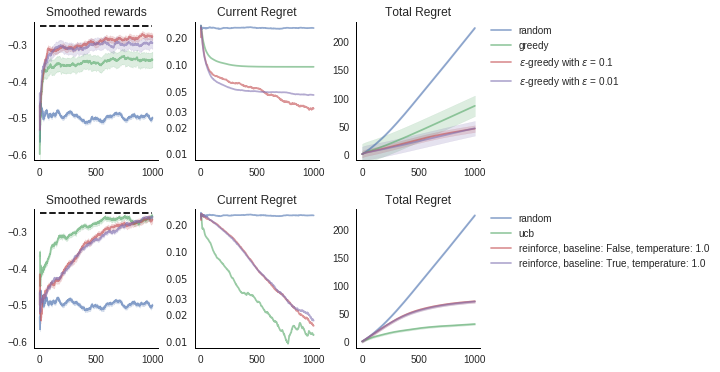

In [0]:
experiment2.show()

## Q6
**[10pts]** Explain which algorithms improved from the changed rewards, and why.

(Use at most two sentences per algorithm and feel free to combine explanations for different algorithms where possible).

In this setting, Greedy and Epsilon (0.1) Greedy algorithms has seen the most improvement when comparing to Experiment 1.

For Greedy, the reason why it has improved because greedy action selection always exploits current knowledge to maximise immediate reward; no time is spent exploring.

For Epsilon (0.1) Greedy, the reason why it has improved is because we are now sampling other actions (perhaps suboptimal) and determining 

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [0]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984

agents = [
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

roving_bandit_class = partial(RovingBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide


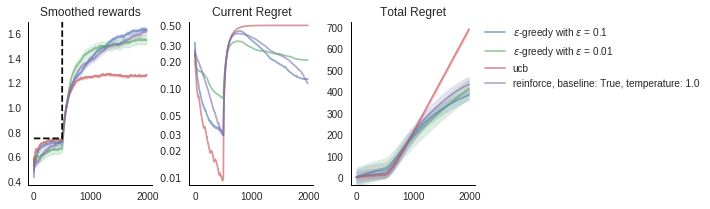

In [0]:
experiment3.show()

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [0]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984

agents = [
    EpsilonGreedy(number_of_arms, 0.1),
    EpsilonGreedy(number_of_arms, 0.01),
    UCB(number_of_arms),
    REINFORCE(number_of_arms, baseline=True),
]

roving_bandit_class = partial(RovingBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in divide


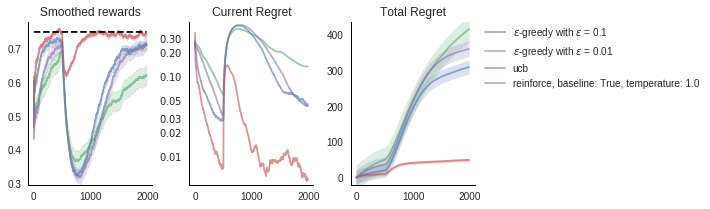

In [0]:
experiment4.show()

## Q7

Observe the reward and regret curves above.  After 500 steps, the rewards change: `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2, which means that the identity of the optimal action changes.

Below, we ask for explanations.  Answer each question briefly, *using at most three sentences per question*.

**[10 pts]** Look at the **current-regret curve** for UCB in **experiment 3**.  Explain why it looks the way it does after the change in rewards.

Below 500 steps we are in our usual setting as shown in experiment 1. From the current regret curve, as soon as we hit the 500th step this is because suddenly we are granted a two-fold reward when we have a failure vs success. We know from the first 500 time steps that certainty of the action value of a success and that hasn't changed therefore UCB is balancing out exploration vs exploitation because we now know we can exploit failure as the reward is double the reward of success and it seems as though UCB didn't take this into account. I think we are also seeing Hoeffding's Inequality bounding the current regret.

**[6 pts]** Explain why the **current-regret curves** for $\epsilon$-greedy look different than that of UCB in **experiment 3**.

The epsilon greedy curves look different from those in ucb due to the algorithm still being greedy by in a way by having a low probability of exploring and hence the slow decline as we are exploiting by estimating action values by averaging past rewards associated with actions and therefore decide to exploit failure. 

**[6 pts]** Explain why the **current-regret curve** for REINFORCE looks different than that of UCB in **experiment 3**.

This is because in gradient bandits we are sampling rewards and because of these changes we can still sample from that different set of rewards and therefore preferences for actions with higher rewards increase more - making them more likely to be selected again i.e choosing failure over success. In this scenario REINFORCE is applying gradient ascent on the expected reward and because our reward has changed on the 500th step we are applying gradient ascent on these new expected rewards again after the 500th step.

**[6 pts]** Compare the **current-regret curve** for UCB in **experiment 3** to the **current regret curve** of UCB in **experiment 4**.  Explain why they differ.

For experiment 4 after the sudden change in the reward system, we then see a sudden decline in the current regret and if we were to ignore the jump then the graph looks like the situation hasn't changed where as experiment 3 showed that upon changing the reward system ucb had a constant regret. The reason why they differ is that because experiment 3 had double the rewards upon failure it means that we should be exploiting this as this is minimising the regret as you maximise reward now. Experiment 4 is simply reversing experiment 1 where we gain +1 reward on failure and 0 on success which is still the same as experiment 1.

**[6 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify the $\epsilon$-greedy algorithm implemented above to deal with that better?  Be specific and concise.

Can use VDBE (value differenced based exploration)-Boltzmann which extends the epsilon greedy algorithm by controlling a state dependent exploration probability, epsilon. The behaviour of this modification is to have the agent more explorative in situations when the knowledge about the environment is uncertain and exploitative when the environment is more certain.

**[6 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

There are methods which aim to tackle this such as the discounted UCB (incorporate a discounting factor $\gamma \in [0,1]$) and the Sliding-windows UCB algorithm (Uses a local empiral average of the observed rewards using on the last $k$ plays) in order to produce UCB for non stationary bandits. This was suggested by Garivier and Moulines in 2008 (https://arxiv.org/pdf/0805.3415.pdf)